# データセットの分割数の違いを感じる
- 学習データで学習 → テストデータでテスト → 誤り率を計算する
- 上記を繰り返して、誤り率の平均と分散を算出する
- CVの分割数 と ホールドアウト割合 を変えて算出する

# 実装のメモ

### アルゴリズムの流れ

1. データセットを取得

2. データセットを学習データと教師データに分割

3. 学習データを元にパラメータを学習

4. 教師データで誤り率を算出

5. 2〜4 を繰り返して、誤り率の標本データを取得し、平均分散を算出

6. 5 を CVの分割数 と ホールドアウトの割合 を変えて算出する


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yoh

In [2]:
def get_data() -> pd.DataFrame:
    '''
    データセットを作成します
    '''
    origin_data = load_breast_cancer()
    df_origin = pd.DataFrame(origin_data.data, columns=origin_data.feature_names)
    df_origin['target'] = origin_data.target
    return df_origin

# test
df_origin = get_data()
df_origin.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
from abc import ABCMeta, abstractmethod


class Spliter(metaclass=ABCMeta):
    '''
    データの分割器です。
    '''
    def __init__(self, df, num):
        '''
        分割器を初期化します。
        '''
        self.df = df
        self.num = num

    @abstractmethod
    def run(self):
        '''
        データの分割を実行します。
        
        :return TrainDataSet, TestDataSet
        '''
        raise NotImplementedError()
        
    def to_str(self):
        return self.__class__.__name__ + '#' + str(self.num)


class FOSpliter(Spliter): 
    '''
    Fold Out法でデータを分割する分割器です。
    '''
    def __init__(self, df, num):
        '''
        :param df 分割したいデータ
        :param num データを分割するレート
        '''
        super().__init__(df, num)
    
    def run(self) -> pd.DataFrame:
        df_train = self.df.sample(frac=self.num, random_state=None)
        df_test = self.df.drop(df_train.index)
        yield df_train, df_test


class CVSpliter(Spliter):
    '''
    Cross Varidation法でデータを分割する分割器です。
    '''
    def __init__(self, df, num):
        '''
        :param df 分割したいデータ
        :param num データの分割する個数
        '''
        super().__init__(df, num)
        
    def run(self) -> pd.DataFrame:
        fold = KFold(n_splits=self.num, shuffle=True, random_state=None)
        for ids_train, ids_test in fold.split(self.df):
            df_train, df_test = self.df.iloc[ids_train], self.df.iloc[ids_test]
            yield df_train, df_test

#  test
df = get_data()
spliter_fo = FOSpliter(df=df, num=0.5)
spliter_cv = CVSpliter(df=df, num=4)
tasks = [spliter_fo, spliter_cv]
for task in tasks:
    print(task.to_str())
    for df_train, df_test in task.run():
        display(df_train.head())
        display(df_test.head())


FOSpliter#0.5


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
78,20.18,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,31.72,170.30,1623.0,0.1639,0.61640,0.7681,0.25080,0.5440,0.09964,0
95,20.26,23.03,132.40,1264.0,0.09078,0.13130,0.14650,0.08683,0.2095,0.05649,...,31.59,156.10,1750.0,0.1190,0.35390,0.4098,0.15730,0.3689,0.08368,0
461,27.42,26.27,186.90,2501.0,0.10840,0.19880,0.36350,0.16890,0.2061,0.05623,...,31.37,251.20,4254.0,0.1357,0.42560,0.6833,0.26250,0.2641,0.07427,0
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.01997,0.01238,0.1573,0.05520,...,26.10,98.91,739.1,0.1050,0.07622,0.1060,0.05185,0.2335,0.06263,1
256,19.55,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,0.06232,...,36.27,178.60,1926.0,0.1281,0.53290,0.4251,0.19410,0.2818,0.10050,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0


CVSpliter#4


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
5,12.45,15.70,82.57,477.1,0.1278,0.1700,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,0
7,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0
9,12.46,24.04,83.97,475.9,0.1186,0.2396,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.2075,0
17,16.13,20.68,108.10,798.8,0.1170,0.2022,0.17220,0.10280,0.2164,0.07356,...,31.48,136.80,1315.0,0.1789,0.4233,0.4784,0.2073,0.3706,0.1142,0
26,14.58,21.53,97.41,644.8,0.1054,0.1868,0.14250,0.08783,0.2252,0.06924,...,33.21,122.40,896.9,0.1525,0.6643,0.5539,0.2701,0.4264,0.1275,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,33.88,123.80,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,0
14,13.73,22.61,93.60,578.3,0.11310,0.22930,0.21280,0.08025,0.2069,0.07682,...,32.01,108.80,697.7,0.1651,0.7725,0.6943,0.22080,0.3596,0.14310,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
2,19.69,21.25,130.0,1203.0,0.10960,0.1599,0.19740,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
8,13.00,21.82,87.5,519.8,0.12730,0.1932,0.18590,0.09353,0.2350,0.07389,...,30.73,106.2,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
11,15.78,17.89,103.6,781.0,0.09710,0.1292,0.09954,0.06606,0.1842,0.06082,...,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.1810,0.3792,0.10480,0
18,19.81,22.15,130.0,1260.0,0.09831,0.1027,0.14790,0.09498,0.1582,0.05395,...,30.88,186.8,2398.0,0.1512,0.3150,0.5372,0.2388,0.2768,0.07615,0
34,16.13,17.88,107.0,807.2,0.10400,0.1559,0.13540,0.07752,0.1998,0.06515,...,27.26,132.7,1261.0,0.1446,0.5804,0.5274,0.1864,0.4270,0.12330,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
2,19.69,21.25,130.00,1203.0,0.10960,0.1599,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.1700,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.1090,0.1127,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
12,19.17,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,0.07800,...,29.94,151.7,1332.0,0.1037,0.3903,0.3639,0.1767,0.3176,0.10230,0
13,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,...,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.1119,0.2809,0.06287,0
15,14.54,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.07364,0.2303,0.07077,...,37.13,124.1,943.2,0.1678,0.6577,0.7026,0.1712,0.4218,0.13410,0


In [4]:
def col_error(df_train: pd.DataFrame, df_test: pd.DataFrame):
    '''
    ロジスティック回帰を用いてテストデータの誤り率を計算します。
    '''
    df_train_x = df_train.drop('target', axis=1)
    df_train_y = df_train['target']
    lr = LogisticRegression()
    lr.fit(df_train_x, df_train_y)
    
    df_test_x = df_test.drop('target', axis=1)
    df_test_y = df_test['target']
    score = lr.score(df_test_x, df_test_y)
    
    return 1- score

# test
df = get_data()
print(col_error(df, df))

0.040421792618629215


In [5]:
class Aggregator():
    '''
    情報を貯蓄して解析する集積器です。
    内部でキーに対応したリストを保持しています。
    '''
    def __init__(self):
        self.values = {}

    def savings(self, key, value):
        '''
        値をキーに対応したリストに保存します。
        '''
        if key not in self.values:
            self.values[key] = []
        self.values[key].append(value)
        pass
    
    def total(self):
        '''
        貯蓄した値を集計します。
        '''
        dict_result = {}
        for key in self.values:
            info = {}
            info['mean'] = np.array(self.values[key]).mean()
            info['var'] = np.array(self.values[key]).var()
            dict_result[key] = info
        return pd.DataFrame.from_dict(dict_result).T
    
    def destory(self):
        '''
        貯蔵した値を破棄します。
        '''
        self.values = {}

memory = Aggregator()
memory.savings('key1', 1)
memory.savings('key1', 2)
memory.savings('key2', 3)
print(memory.values)

{'key1': [1, 2], 'key2': [3]}


In [6]:
class drawthy:
    """
    グラフを描画するクラスです。
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        

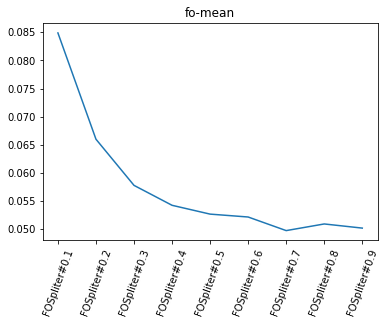

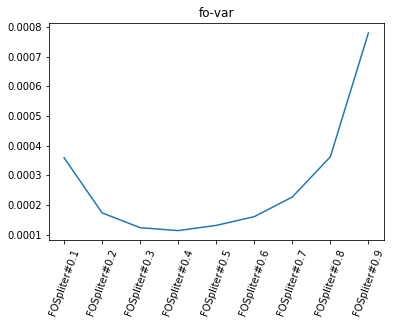

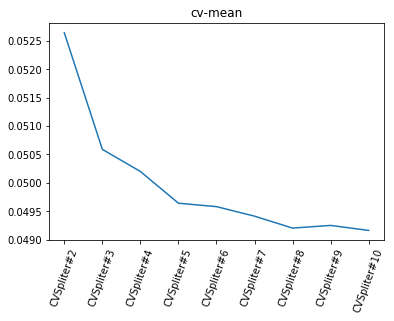

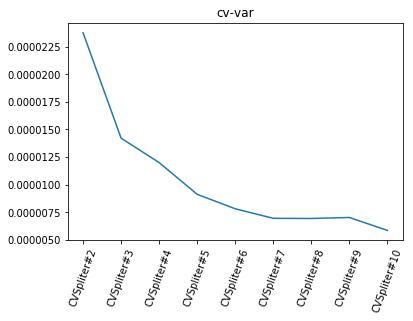

In [7]:
def run_task(memory, task):
    error = []
    for df_train, df_test in task.run():
        error.append(col_error(df_train, df_test))
    memory.savings(task.to_str(), np.mean(error))
    return memory

def run_tasks(memory, tasks):
    for task in tasks:
        memory = run_task(memory, task)
    return memory

def main():
    memory = Aggregator()
    for i in range(1000):
        df_origin = get_data()
        tasks_fo = [FOSpliter(df=df_origin, num=round(num*0.1, 1)) for num in range(1, 10)]
        tasks_cv = [CVSpliter(df=df_origin, num=(num)) for num in range(2, 11)]
        tasks = tasks_fo + tasks_cv
        memory = run_tasks(memory, tasks)
    df_total = memory.total()
    df_total_fo = df_total[df_total.index.str.contains('FO')]
    df_total_cv = df_total[df_total.index.str.contains('CV')]
#     display(df_total_fo)
#     display(df_total_cv)
    
    # plot
    plt.plot(df_total_fo.index, df_total_fo['mean'])
    plt.title('fo-mean')
    plt.xticks(rotation=70)
    plt.show()
    plt.plot(df_total_fo.index, df_total_fo['var'])
    plt.title('fo-var')
    plt.xticks(rotation=70)
    plt.show()
    
    plt.plot(df_total_cv.index, df_total_cv['mean'])
    plt.title('cv-mean')
    plt.xticks(rotation=70)
    plt.show()
    plt.plot(df_total_cv.index, df_total_cv['var'])
    plt.title('cv-var')
    plt.xticks(rotation=70)
    plt.show()

main()

## 考察

Fold Out 法

平均値 → 学習データの割合を増やすごとに減少している。

なぜ？

学習データの割合を増やすと少ない場合に比べて学習が十分にできる。

すると、モデルの判別性能が向上して、全体的に誤り率が減少する。

つまり、全体的な誤り率も減少するので平均値が減少した。


分散 → 学習データの割合を0.5あたりにした時が最小になっている。

なぜ？

学習データの割合が低いときは、テスト用のデータが多いので正しく評価できるが、そもそもの判別精度が十分では無いので、分散が大きくなる。

学習データの割合が多いときは、判別精度は十分であるが、テストデータが不足するために、正しく評価できないので分散が大きくなる。


Cross Varidation 法

平均値 → 分割数を増やすごとに減少している

なぜ？　

分割数を増やすことで、学習に使うデータセットの数が増える。

それにより、FoldOut法と同じように学習が十分に行われて全体的に誤り率が減少した。

つまり、誤り率の平均値も減少した。

分散 → 分割数を増やすごとに減少している

なぜ？

Cross Varidation法では、分割数を増やしても、全ての学習データがテストに使用した平均を取るため、評価の精度が低下しない。

したがって、分散も減少していく。
